In [48]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc


In [49]:
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
df_test= pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
print(df_train.head())
print(df_test.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


In [50]:
y_train = df_train.pop('survived')
y_test = df_test.pop('survived')

In [51]:
df_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [52]:
df_train.shape

(627, 9)

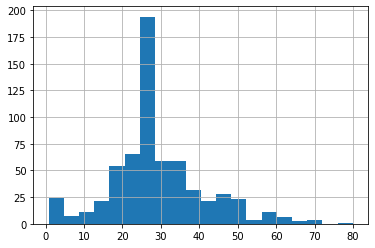

In [53]:
df_train.age.hist(bins=20)

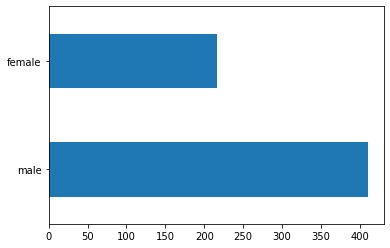

In [54]:
df_train.sex.value_counts().plot(kind='barh')

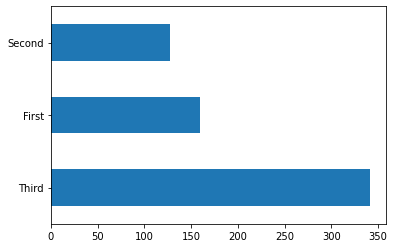

In [55]:
df_train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

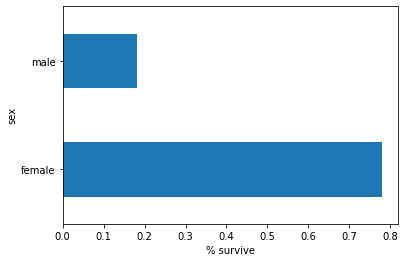

In [56]:
pd.concat([df_train,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [57]:
df_train.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [58]:
categorical_columns = ['sex','n_siblings_spouses', 'parch','class', 'deck',
       'embark_town', 'alone']

numerical_columns = ['age','fare']

In [67]:
feature_columns = []

for feature in categorical_columns:
  vocabulary = df_train[feature].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature,vocabulary))

In [68]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [69]:
for feature in numerical_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature,dtype=tf.float32))

In [70]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [79]:
def make_input_fn(data_df,label_df,num_epochs=10,shuffle=True,batch_size=32) :
  def input_function() :
    ds= tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds =ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(df_train,y_train)
test_input_fn = make_input_fn(df_test,y_test,num_epochs=1,shuffle=False)

In [80]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8tunr_vn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [81]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)
clear_output()
print(result['accuracy'])

0.7348485


In [82]:
result

{'accuracy': 0.7348485,
 'accuracy_baseline': 0.625,
 'auc': 0.8262626,
 'auc_precision_recall': 0.7975412,
 'average_loss': 0.4946886,
 'global_step': 200,
 'label/mean': 0.375,
 'loss': 0.48900148,
 'precision': 0.64356434,
 'prediction/mean': 0.44066617,
 'recall': 0.65656567}

In [91]:
result = list(linear_est.predict(test_input_fn))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8tunr_vn/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [94]:
result[0]['probabilities'][1]

0.13161148

In [95]:
df_test.iloc[0]

sex                          male
age                            35
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object

In [97]:
print(df_test.iloc[2])
print(result[2]['probabilities'][1])
y_test[2]

sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
0.82535714


1